In [31]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [14]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [16]:
model_conf = confs.distilbert_conf

# Datos ConvAI

In [17]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [18]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [19]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [20]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [21]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [22]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [23]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0460137371817533 	 Validation loss: 2.008292224447606 	 
  1%|          | 574/57400 [02:16<3:24:23,  4.63it/s]
Epoch 2 	 Training loss: 1.9954669581473081 	 Validation loss: 1.9923823991064298 	 
  2%|▏         | 1148/57400 [04:52<4:02:16,  3.87it/s]
Epoch 3 	 Training loss: 1.9801716659127213 	 Validation loss: 1.9855626195164051 	 
  3%|▎         | 1722/57400 [07:33<4:25:03,  3.50it/s]
Epoch 4 	 Training loss: 1.9750663515582734 	 Validation loss: 1.9880940429234908 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [10:15<4:17:00,  3.57it/s]
Epoch 5 	 Training loss: 1.9719064675972438 	 Validation loss: 1.9859158447233296 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [13:26<4:48:53,  3.15it/s]
Epoch 6 	 Training loss: 1.9654237036090279 	 Validation loss: 1.979166790590448 	 
  6%|▌         | 3444/57400 [16:13<4:15:41,  3.52it/s]
Epoch 7 	 Training loss: 1.9628305549405594 	 Validation loss: 1.9782694840835313 	 
  7%|▋         | 401

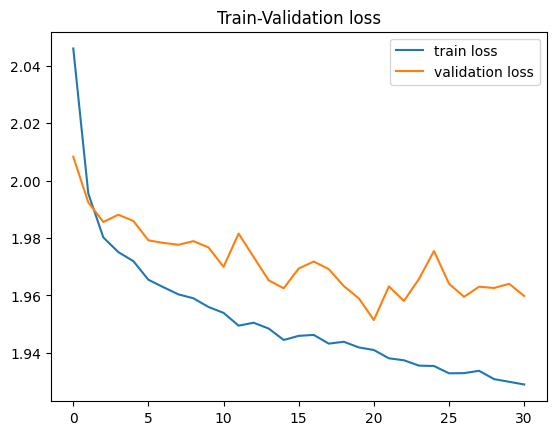

In [24]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_simple_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [25]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('distilbert_multitask_simple_1'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6565656565656566, 'precision': 0.6565656565656566, 'f1': 0.6565656565656566, 'accuracy': 0.6565656565656566}, 'as': {'recall': 0.7170795306388527, 'precision': 0.7170795306388527, 'f1': 0.7170795306388528, 'accuracy': 0.7170795306388527}, 'about': {'recall': 0.8188775510204082, 'precision': 0.8188775510204082, 'f1': 0.8188775510204082, 'accuracy': 0.8188775510204082}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6739659367396593, 'precision': 0.6739659367396593, 'f1': 0.6739659367396593, 'accuracy': 0.6739659367396593}, 'as': {'recall': 0.6767676767676768, 'precision': 0.6767676767676768, 'f1': 0.6767676767676768, 'accuracy': 0.6767676767676768}, 'about': {'recall': 0.8151041666666666, 'precision': 0.8151041666666666, 'f1': 0.8151041666666666, 'accuracy': 0.8151041666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6377952755905512, 'precision': 0.6377952755905512, 'f1': 0.6377952755905512, 'accuracy': 0.6377952755905512}, 'a

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.053028464940367 	 Validation loss: 2.0212745060354975 	 
  1%|          | 574/57400 [02:08<3:39:25,  4.32it/s]
Epoch 2 	 Training loss: 1.9926879966715902 	 Validation loss: 1.9956677970239671 	 
  2%|▏         | 1148/57400 [04:15<2:50:28,  5.50it/s]
Epoch 3 	 Training loss: 1.9806977400380976 	 Validation loss: 1.9790226322109417 	 
  3%|▎         | 1722/57400 [06:22<3:26:31,  4.49it/s]
Epoch 4 	 Training loss: 1.9743665087098443 	 Validation loss: 1.976284701945418 	 
  4%|▍         | 2296/57400 [08:30<2:34:46,  5.93it/s]
Epoch 5 	 Training loss: 1.9707406015761637 	 Validation loss: 1.9788167395834195 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:37<3:10:45,  4.76it/s]
Epoch 6 	 Training loss: 1.9660440631444447 	 Validation loss: 1.98192655838142 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:47<2:39:52,  5.62it/s]
Epoch 7 	 Training loss: 1.9623010800275238 	 Validation loss: 1.9801555750733715 	 

3 epoch without impro

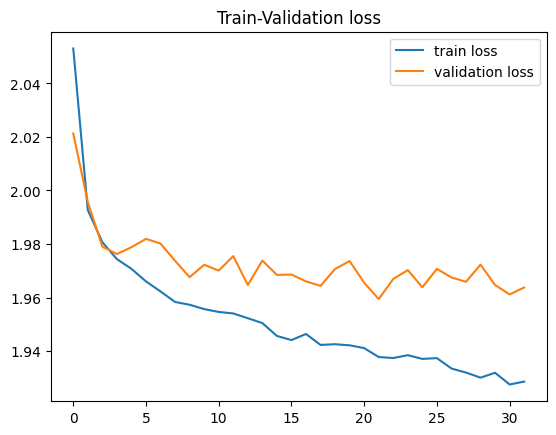

In [26]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_simple_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [27]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6578282828282829, 'precision': 0.6578282828282829, 'f1': 0.6578282828282829, 'accuracy': 0.6578282828282829}, 'as': {'recall': 0.7196870925684485, 'precision': 0.7196870925684485, 'f1': 0.7196870925684485, 'accuracy': 0.7196870925684485}, 'about': {'recall': 0.8125, 'precision': 0.8125, 'f1': 0.8125, 'accuracy': 0.8125}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6593673965936739, 'precision': 0.6593673965936739, 'f1': 0.6593673965936739, 'accuracy': 0.6593673965936739}, 'as': {'recall': 0.6691919191919192, 'precision': 0.6691919191919192, 'f1': 0.6691919191919192, 'accuracy': 0.6691919191919192}, 'about': {'recall': 0.7994791666666666, 'precision': 0.7994791666666666, 'f1': 0.7994791666666666, 'accuracy': 0.7994791666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6561679790026247, 'precision': 0.6561679790026247, 'f1': 0.6561679790026247, 'accuracy': 0.6561679790026247}, 'as': {'recall': 0.7735849056603774, 'precision': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.046503994107662 	 Validation loss: 2.008144392805584 	 
  1%|          | 574/57400 [03:12<4:23:46,  3.59it/s]
Epoch 2 	 Training loss: 1.992902584607593 	 Validation loss: 1.998273132211071 	 
  2%|▏         | 1148/57400 [06:21<4:39:18,  3.36it/s]
Epoch 3 	 Training loss: 1.9830199033541132 	 Validation loss: 1.9876103744668476 	 
  3%|▎         | 1722/57400 [09:22<3:46:09,  4.10it/s]
Epoch 4 	 Training loss: 1.9750693924335652 	 Validation loss: 1.9807635889214985 	 
  4%|▍         | 2296/57400 [12:10<5:45:09,  2.66it/s]
Epoch 5 	 Training loss: 1.970376918332502 	 Validation loss: 1.9879700854673223 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [15:04<4:25:27,  3.42it/s]
Epoch 6 	 Training loss: 1.9683079410097741 	 Validation loss: 1.975454419346179 	 
  6%|▌         | 3444/57400 [17:56<4:19:00,  3.47it/s]
Epoch 7 	 Training loss: 1.9635294148315536 	 Validation loss: 1.9684062448598572 	 
  7%|▋         | 4018/57400 [20:51<5:55:07,  2.51it/s

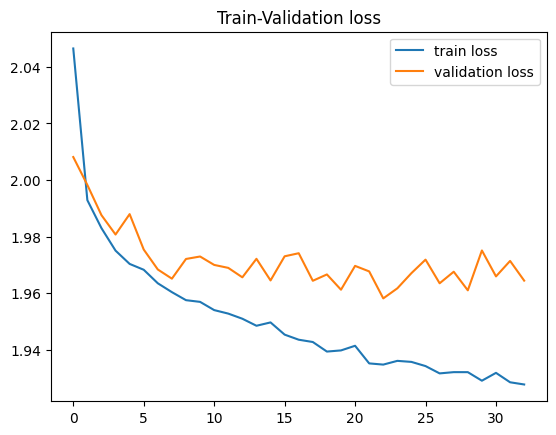

In [28]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_simple_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [29]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6603535353535354, 'precision': 0.6603535353535354, 'f1': 0.6603535353535354, 'accuracy': 0.6603535353535354}, 'as': {'recall': 0.7209908735332464, 'precision': 0.7209908735332464, 'f1': 0.7209908735332464, 'accuracy': 0.7209908735332464}, 'about': {'recall': 0.8073979591836735, 'precision': 0.8073979591836735, 'f1': 0.8073979591836735, 'accuracy': 0.8073979591836735}} 

Evaluación en etiquetas male
{'to': {'recall': 0.656934306569343, 'precision': 0.656934306569343, 'f1': 0.656934306569343, 'accuracy': 0.656934306569343}, 'as': {'recall': 0.6641414141414141, 'precision': 0.6641414141414141, 'f1': 0.6641414141414141, 'accuracy': 0.6641414141414141}, 'about': {'recall': 0.7942708333333334, 'precision': 0.7942708333333334, 'f1': 0.7942708333333333, 'accuracy': 0.7942708333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562}, 'as': 

In [32]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8129251700680272, 'precision': 0.8129251700680272, 'f1': 0.8129251700680272, 'accuracy': 0.8129251700680272}
Métricas etiqueta male: {'recall': 0.8029513888888888, 'precision': 0.8029513888888888, 'f1': 0.8029513888888888, 'accuracy': 0.8029513888888888}
Métricas etiqueta female:  {'recall': 0.8225, 'precision': 0.8225, 'f1': 0.8225, 'accuracy': 0.8225}

 to
Resultado global: {'recall': 0.6582491582491583, 'precision': 0.6582491582491583, 'f1': 0.6582491582491583, 'accuracy': 0.6582491582491583}
Métricas etiqueta male: {'recall': 0.6634225466342254, 'precision': 0.6634225466342254, 'f1': 0.6634225466342254, 'accuracy': 0.6634225466342254}
Métricas etiqueta female:  {'recall': 0.652668416447944, 'precision': 0.652668416447944, 'f1': 0.652668416447944, 'accuracy': 0.652668416447944}

 as
Resultado global: {'recall': 0.7192524989135158, 'precision': 0.7192524989135158, 'f1': 0.719252498913516, 'accuracy': 0.7192524989135158}
Métr